<a href="https://colab.research.google.com/github/GarimaRay/venting-companion/blob/main/Venting_Companinon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()   # upload goemotions_1.csv, goemotions_2.csv, goemotions_3.csv (or your single CSV)


Saving goemotions_2.csv to goemotions_2.csv
Saving goemotions_3.csv to goemotions_3.csv
Saving goemotions_1.csv to goemotions_1.csv


In [2]:
import pandas as pd

# If you uploaded multiple CSVs (like goemotions_1.csv, goemotions_2.csv, goemotions_3.csv),
# this loads all .csv files and concatenates them.
csv_files = [fn for fn in uploaded.keys() if fn.lower().endswith(".csv")]
print("CSV files found:", csv_files)

dfs = [pd.read_csv(fn) for fn in csv_files]
df = pd.concat(dfs, ignore_index=True)

print(" Combined dataset shape:", df.shape)


CSV files found: ['goemotions_2.csv', 'goemotions_3.csv', 'goemotions_1.csv']
 Combined dataset shape: (211225, 37)


In [3]:
print(" Columns:", df.columns.tolist())
display(df.head(5))


 Columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


text       id  \
0                                        We can hope  ee3o3ko   
1                     Shhh don't give them the idea!  eebl3z7   
2  Thank you so much, kind stranger. I really nee...  ed4fe9l   
3  Ion know but it would be better for you to jus...  efavtdu   
4  I'm honestly surprised. We should have fallen ...  ee2imz2   

               author            subreddit    link_id   parent_id  \
0       darkenseyreth       EdmontonOilers  t3_ag4r9j  t1_ee3mhad   
1   BoinkBoinkEtAliae      MurderedByWords  t3_ah3o76  t1_eeb68lo   
2          savageleaf  raisedbynarcissists  t3_abwh00  t1_ed4etbj   
3           CADDiLLXC              darknet  t3_al4njw   t3_al4njw   
4  CorporalThornberry    CollegeBasketball  t3_afxt6t  t1_ee22nyr   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.547529e+09        62                 False           0  ...     0   
1  1.547777e+09        76                 False           0  ...     0   
2  1.546482e+09        24                 False           0  ...     0   
3  1.548800e+09        62                 False           0  ...     0   
4  1.547497e+09        55                 False           0  ...     0   

   nervousness  optimism  pride  realization  relief  remorse  sadness  \
0            0         1      0            0       0        0        0   
1            0         0      0            0       0        0        0   
2            0         0      0            0       0        0        0   
3            0         0      0            0       0        0        0   
4            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        0  
1         0        0  
2         0        0  
3         0        1  
4         0        0  

[5 rows x 37 columns]

In [4]:
# Try common text column names
possible_text_cols = ["text", "comment", "sentence", "content"]
text_col = None

for c in possible_text_cols:
    if c in df.columns:
        text_col = c
        break

# If not found, pick the first object/string column as text (fallback)
if text_col is None:
    object_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if len(object_cols) > 0:
        text_col = object_cols[0]

print("Detected text column:", text_col)


Detected text column: text


In [5]:
import numpy as np

# Label columns = numeric columns that contain only 0/1 (ignoring NaN)
label_cols = []
for c in df.columns:
    if c == text_col:
        continue
    if pd.api.types.is_numeric_dtype(df[c]):
        unique_vals = set(pd.Series(df[c].dropna().unique()).tolist())
        if unique_vals.issubset({0, 1}):
            label_cols.append(c)

# Sometimes GoEmotions has an extra column like "example_very_unclear" (not an emotion)
if "example_very_unclear" in label_cols:
    label_cols.remove("example_very_unclear")

print("Detected label columns count:", len(label_cols))
print("Example labels:", label_cols[:10])

# Metadata columns = everything that is NOT text and NOT label
metadata_cols = [c for c in df.columns if c not in ([text_col] + label_cols)]
print("\n Metadata columns (excluded from modeling):")
print(metadata_cols)


Detected label columns count: 28
Example labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment']

 Metadata columns (excluded from modeling):
['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']


In [6]:
model_df = df[[text_col] + label_cols].copy()

print("Modeling dataframe shape:", model_df.shape)
display(model_df.head(3))


Modeling dataframe shape: (211225, 29)


text  admiration  amusement  \
0                                        We can hope           0          0   
1                     Shhh don't give them the idea!           0          0   
2  Thank you so much, kind stranger. I really nee...           0          0   

   anger  annoyance  approval  caring  confusion  curiosity  desire  ...  \
0      0          0         0       0          0          0       0  ...   
1      1          0         0       0          0          0       0  ...   
2      0          0         0       0          0          0       0  ...   

   love  nervousness  optimism  pride  realization  relief  remorse  sadness  \
0     0            0         1      0            0       0        0        0   
1     0            0         0      0            0       0        0        0   
2     0            0         0      0            0       0        0        0   

   surprise  neutral  
0         0        0  
1         0        0  
2         0        0  

[3 rows x 29 columns]

In [7]:
# Check missing values
missing = model_df.isnull().sum()

print("Missing values per column:")
print(missing[missing > 0])


Missing values per column:
Series([], dtype: int64)


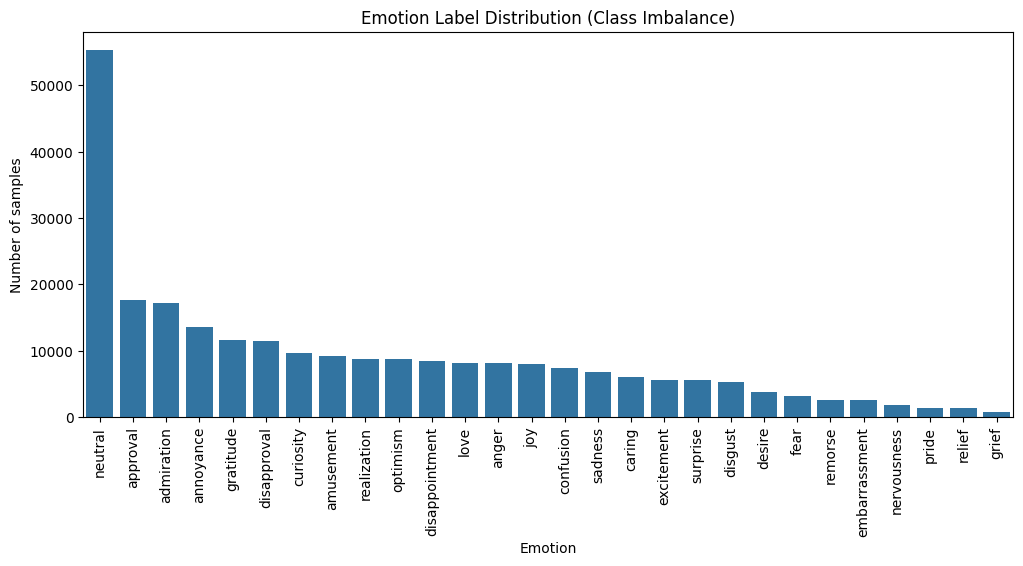

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many times each emotion appears
label_counts = model_df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=90)
plt.title("Emotion Label Distribution (Class Imbalance)")
plt.ylabel("Number of samples")
plt.xlabel("Emotion")
plt.show()


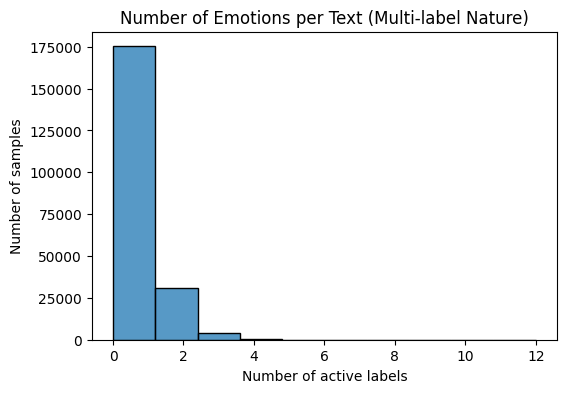

0       3411
1     171820
2      31187
3       4218
4        399
5        106
6         53
7         20
8          6
9          3
10         1
12         1
Name: count, dtype: int64


In [9]:
# Count how many emotions are active per text
labels_per_sample = model_df[label_cols].sum(axis=1)

plt.figure(figsize=(6, 4))
sns.histplot(labels_per_sample, bins=10, kde=False)
plt.title("Number of Emotions per Text (Multi-label Nature)")
plt.xlabel("Number of active labels")
plt.ylabel("Number of samples")
plt.show()

print(labels_per_sample.value_counts().sort_index())


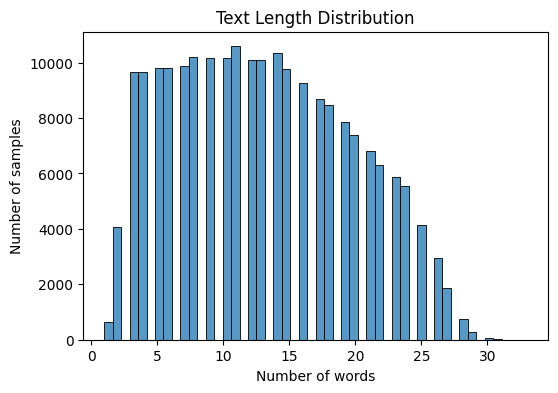

count    211225.000000
mean         12.997188
std           6.676105
min           1.000000
25%           7.000000
50%          13.000000
75%          18.000000
max          33.000000
Name: text, dtype: float64


In [10]:
# Compute text length (number of words)
text_lengths = model_df[text_col].str.split().apply(len)

plt.figure(figsize=(6, 4))
sns.histplot(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Number of samples")
plt.show()

print(text_lengths.describe())


In [11]:
import re

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+", " ", t)   # remove URLs
    t = re.sub(r"\s+", " ", t).strip()     # remove extra spaces
    return t

# Apply cleaning
model_df[text_col] = model_df[text_col].astype(str).apply(clean_text)

# Preview cleaned text
display(model_df[[text_col]].head(5))


text
0                                        we can hope
1                     shhh don't give them the idea!
2  thank you so much, kind stranger. i really nee...
3  ion know but it would be better for you to jus...
4  i'm honestly surprised. we should have fallen ...

In [12]:
# X = input texts
X = model_df[text_col].values

# Y = multi-label matrix (0/1 for each emotion)
Y = model_df[label_cols].values.astype(int)

print(" done X shape:", X.shape)
print(" done Y shape:", Y.shape)
print(" done Unique values in Y:", set(Y.flatten()))


 done X shape: (211225,)
 done Y shape: (211225, 28)
 done Unique values in Y: {np.int64(0), np.int64(1)}


In [13]:
# Example: suppose a model outputs probabilities for 28 emotions
dummy_probs = np.array([0.10, 0.80, 0.49, 0.51])

threshold = 0.50
dummy_pred = (dummy_probs >= threshold).astype(int)

print("Probabilities:", dummy_probs)
print("Threshold:", threshold)
print("Binary prediction:", dummy_pred)


Probabilities: [0.1  0.8  0.49 0.51]
Threshold: 0.5
Binary prediction: [0 1 0 1]


In [14]:
from sklearn.model_selection import train_test_split

# 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print("done Train shapes:", X_train.shape, Y_train.shape)
print("done Test shapes: ", X_test.shape, Y_test.shape)


done Train shapes: (168980,) (168980, 28)
done Test shapes:  (42245,) (42245, 28)


In [15]:
# Split train into train/val (90/10 of train)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

print("done Final splits:")
print("Train:", X_train.shape, Y_train.shape)
print("Val:  ", X_val.shape, Y_val.shape)
print("Test: ", X_test.shape, Y_test.shape)


done Final splits:
Train: (152082,) (152082, 28)
Val:   (16898,) (16898, 28)
Test:  (42245,) (42245, 28)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into TF-IDF features
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec = tfidf.fit_transform(X_train)
X_val_vec   = tfidf.transform(X_val)
X_test_vec  = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_vec.shape)


TF-IDF train shape: (152082, 50000)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# One-vs-Rest Logistic Regression for multi-label classification
logreg = OneVsRestClassifier(
    LogisticRegression(
        solver="liblinear",
        max_iter=300,
        class_weight="balanced"
    )
)

logreg.fit(X_train_vec, Y_train)

print("Done Logistic Regression training completed")


Done Logistic Regression training completed


In [18]:
from sklearn.metrics import f1_score, accuracy_score

# Predict on validation set
Y_val_pred_lr = logreg.predict(X_val_vec)

# Metrics
val_micro_f1 = f1_score(Y_val, Y_val_pred_lr, average="micro", zero_division=0)
val_macro_f1 = f1_score(Y_val, Y_val_pred_lr, average="macro", zero_division=0)
val_subset_acc = accuracy_score(Y_val, Y_val_pred_lr)

print("Logistic Regression (VAL)")
print("Micro F1 :", val_micro_f1)
print("Macro F1 :", val_macro_f1)
print("Subset Acc:", val_subset_acc)


Logistic Regression (VAL)
Micro F1 : 0.34383205670671146
Macro F1 : 0.3025892218249032
Subset Acc: 0.06604331873594509


In [19]:
# Predict on test set
Y_test_pred_lr = logreg.predict(X_test_vec)

test_micro_f1 = f1_score(Y_test, Y_test_pred_lr, average="micro", zero_division=0)
test_macro_f1 = f1_score(Y_test, Y_test_pred_lr, average="macro", zero_division=0)
test_subset_acc = accuracy_score(Y_test, Y_test_pred_lr)

print("Logistic Regression (TEST)")
print("Micro F1 :", test_micro_f1)
print("Macro F1 :", test_macro_f1)
print("Subset Acc:", test_subset_acc)


Logistic Regression (TEST)
Micro F1 : 0.34406802684126164
Macro F1 : 0.30343949464957015
Subset Acc: 0.06540418984495207


In [20]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Define Linear SVM with One-vs-Rest
svm_clf = OneVsRestClassifier(
    LinearSVC(
        class_weight="balanced",
        max_iter=5000
    )
)

# Train on TF-IDF vectors
svm_clf.fit(X_train_vec, Y_train)

print("Done Linear SVM training completed")


Done Linear SVM training completed


In [21]:
# Predict on test set
Y_test_pred_svm = svm_clf.predict(X_test_vec)

# Metrics
test_micro_f1 = f1_score(Y_test, Y_test_pred_svm, average="micro", zero_division=0)
test_macro_f1 = f1_score(Y_test, Y_test_pred_svm, average="macro", zero_division=0)
test_subset_acc = accuracy_score(Y_test, Y_test_pred_svm)

print("Linear SVM (TEST)")
print("Micro F1 :", test_micro_f1)
print("Macro F1 :", test_macro_f1)
print("Subset Acc:", test_subset_acc)


Linear SVM (TEST)
Micro F1 : 0.35702058725151337
Macro F1 : 0.30634494161483977
Subset Acc: 0.11572967215055036


In [22]:
!pip install transformers torch
!pip install tokenizers

In [23]:
from transformers import pipeline

# Load the multi-label classification model
classifier = pipeline(
    "text-classification",
    model="SamLowe/roberta-base-go_emotions",
    top_k=None   # return all labels with probabilities
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0


In [24]:
# Example usage
texts = ["I am having a tough day but hopeful."]
outputs = classifier(texts)

print(outputs)

[[{'label': 'optimism', 'score': 0.6914082765579224}, {'label': 'sadness', 'score': 0.2170925736427307}, {'label': 'caring', 'score': 0.13288134336471558}, {'label': 'disappointment', 'score': 0.1315603256225586}, {'label': 'desire', 'score': 0.0418446883559227}, {'label': 'fear', 'score': 0.03774157911539078}, {'label': 'neutral', 'score': 0.03261668607592583}, {'label': 'nervousness', 'score': 0.028492743149399757}, {'label': 'remorse', 'score': 0.02467987686395645}, {'label': 'disapproval', 'score': 0.020787866786122322}, {'label': 'approval', 'score': 0.019691938534379005}, {'label': 'realization', 'score': 0.01369533222168684}, {'label': 'annoyance', 'score': 0.010533355176448822}, {'label': 'grief', 'score': 0.008433867245912552}, {'label': 'admiration', 'score': 0.008189172483980656}, {'label': 'love', 'score': 0.006364846136420965}, {'label': 'joy', 'score': 0.005852018482983112}, {'label': 'relief', 'score': 0.005354621447622776}, {'label': 'confusion', 'score': 0.005213266238

In [25]:
print(X_val[:2])
print(Y_val[:2])
print(Y_val.shape)

['i find that a normal chat in chinese can sometimes have that effect too.'
 "he wasn't beat over the top all season. i think the longest pass he allowed was around 20 yards."]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
(16898, 28)


In [26]:
id2label = classifier.model.config.id2label
for i in range(28):
    print(i, id2label[i])
Y_val[0]

0 admiration
1 amusement
2 anger
3 annoyance
4 approval
5 caring
6 confusion
7 curiosity
8 desire
9 disappointment
10 disapproval
11 disgust
12 embarrassment
13 excitement
14 fear
15 gratitude
16 grief
17 joy
18 love
19 nervousness
20 optimism
21 pride
22 realization
23 relief
24 remorse
25 sadness
26 surprise
27 neutral


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0])

In [27]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# Inference
val_preds = classifier(
    list(X_val),
    batch_size=32,
    truncation=True
)

# Scores matrix
y_scores = np.array([
    [l["score"] for l in sample]
    for sample in val_preds
])

y_true = Y_val

In [28]:
print(y_scores.shape, y_true.shape)

(16898, 28) (16898, 28)


In [29]:
threshold = 0.5
y_pred = (y_scores >= threshold).astype(int)

print("Micro F1:", f1_score(y_true, y_pred, average="micro"))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

print(
    classification_report(
        y_true,
        y_pred,
        target_names=list(id2label.values()),
        zero_division=0
    )
)

Micro F1: 0.07638487336648549
Macro F1: 0.010458018440610109
                precision    recall  f1-score   support

    admiration       0.09      0.90      0.16      1358
     amusement       0.14      0.13      0.13       747
         anger       0.00      0.00      0.00       627
     annoyance       0.00      0.00      0.00      1062
      approval       0.00      0.00      0.00      1394
        caring       0.00      0.00      0.00       484
     confusion       0.00      0.00      0.00       592
     curiosity       0.00      0.00      0.00       766
        desire       0.00      0.00      0.00       286
disappointment       0.00      0.00      0.00       652
   disapproval       0.00      0.00      0.00       954
       disgust       0.00      0.00      0.00       390
 embarrassment       0.00      0.00      0.00       213
    excitement       0.00      0.00      0.00       482
          fear       0.00      0.00      0.00       229
     gratitude       0.00      0.00      0

In [30]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score


In [31]:
def run_kfold_cv(model_name, model, X, Y, n_splits=5, seed=42, max_samples=None):
    """
    Runs K-Fold CV for multi-label classification.
    - model: sklearn estimator (already wrapped in OneVsRest if needed)
    - X: list/array of texts
    - Y: multi-label matrix (0/1) shape: (n_samples, n_labels)
    - max_samples: if not None, uses only first max_samples to reduce runtime
    """

    # Optional: speed-up for Colab by using fewer samples
    if max_samples is not None:
        X = X[:max_samples]
        Y = Y[:max_samples]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
        X_tr, X_va = X[train_idx], X[val_idx]
        Y_tr, Y_va = Y[train_idx], Y[val_idx]

        # Pipeline = TF-IDF + Model (so TF-IDF is trained only on fold-train)
        pipe = Pipeline([
            ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
            ("clf", model)
        ])

        pipe.fit(X_tr, Y_tr)
        Y_pred = pipe.predict(X_va)

        # Metrics (same as your previous evaluation style)
        micro_f1 = f1_score(Y_va, Y_pred, average="micro", zero_division=0)
        macro_f1 = f1_score(Y_va, Y_pred, average="macro", zero_division=0)
        subset_acc = accuracy_score(Y_va, Y_pred)

        fold_results.append({
            "model": model_name,
            "fold": fold,
            "micro_f1": micro_f1,
            "macro_f1": macro_f1,
            "subset_acc": subset_acc
        })

        print(f"[{model_name}] Fold {fold}/{n_splits} -> Micro-F1={micro_f1:.4f}, Macro-F1={macro_f1:.4f}, SubsetAcc={subset_acc:.4f}")

    results_df = pd.DataFrame(fold_results)

    # Summary row (mean across folds)
    summary = results_df[["micro_f1", "macro_f1", "subset_acc"]].mean().to_dict()
    print("\n=== CV Mean (Average across folds) ===")
    print({k: round(v, 4) for k, v in summary.items()})

    return results_df


In [32]:
# Recommended: run CV on TRAIN ONLY (keeps your test set clean)
X_cv = X_train
Y_cv = Y_train

# If X_train is a python list, convert to numpy array for indexing
X_cv = np.array(X_cv)
Y_cv = np.array(Y_cv)


In [33]:
logreg_model = OneVsRestClassifier(
    LogisticRegression(
        solver="liblinear",
        max_iter=300,
        class_weight="balanced"
    )
)

logreg_cv_df = run_kfold_cv(
    model_name="Logistic Regression (OvR)",
    model=logreg_model,
    X=X_cv,
    Y=Y_cv,
    n_splits=5,
    seed=42,
    max_samples=30000   # change to None for full training
)


[Logistic Regression (OvR)] Fold 1/5 -> Micro-F1=0.3543, Macro-F1=0.2934, SubsetAcc=0.1313
[Logistic Regression (OvR)] Fold 2/5 -> Micro-F1=0.3553, Macro-F1=0.3050, SubsetAcc=0.1350
[Logistic Regression (OvR)] Fold 3/5 -> Micro-F1=0.3576, Macro-F1=0.3100, SubsetAcc=0.1303
[Logistic Regression (OvR)] Fold 4/5 -> Micro-F1=0.3538, Macro-F1=0.3091, SubsetAcc=0.1333
[Logistic Regression (OvR)] Fold 5/5 -> Micro-F1=0.3500, Macro-F1=0.2963, SubsetAcc=0.1352

=== CV Mean (Average across folds) ===
{'micro_f1': 0.3542, 'macro_f1': 0.3028, 'subset_acc': 0.133}


In [34]:
svm_model = OneVsRestClassifier(
    LinearSVC(
        class_weight="balanced",
        max_iter=5000
    )
)

svm_cv_df = run_kfold_cv(
    model_name="Linear SVM (OvR)",
    model=svm_model,
    X=X_cv,
    Y=Y_cv,
    n_splits=5,
    seed=42,
    max_samples=30000   # change to None for full training
)


[Linear SVM (OvR)] Fold 1/5 -> Micro-F1=0.3423, Macro-F1=0.2688, SubsetAcc=0.1927
[Linear SVM (OvR)] Fold 2/5 -> Micro-F1=0.3321, Macro-F1=0.2696, SubsetAcc=0.1858
[Linear SVM (OvR)] Fold 3/5 -> Micro-F1=0.3362, Macro-F1=0.2801, SubsetAcc=0.1847
[Linear SVM (OvR)] Fold 4/5 -> Micro-F1=0.3394, Macro-F1=0.2806, SubsetAcc=0.1942
[Linear SVM (OvR)] Fold 5/5 -> Micro-F1=0.3331, Macro-F1=0.2689, SubsetAcc=0.1913

=== CV Mean (Average across folds) ===
{'micro_f1': 0.3366, 'macro_f1': 0.2736, 'subset_acc': 0.1897}


In [35]:
cv_all = pd.concat([logreg_cv_df, svm_cv_df], ignore_index=True)

summary_table = (
    cv_all.groupby("model")[["micro_f1", "macro_f1", "subset_acc"]]
    .mean()
    .sort_values("micro_f1", ascending=False)
)

summary_table


micro_f1  macro_f1  subset_acc
model                                                    
Logistic Regression (OvR)  0.354193  0.302765    0.133033
Linear SVM (OvR)           0.336629  0.273601    0.189733

In [36]:
!pip -q install shap


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

# Choose ONE emotion label to explain
target_label = "sadness"   # you can change this to "joy", "anger", etc.

label_index = label_cols.index(target_label)

# Train binary model for that one label
y_train_one = Y_train[:, label_index]
y_val_one   = Y_val[:, label_index]

shap_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2))),
    ("clf", LogisticRegression(solver="liblinear", max_iter=300, class_weight="balanced"))
])

shap_pipe.fit(X_train, y_train_one)

print("Trained SHAP model for label:", target_label)


Trained SHAP model for label: sadness


In [38]:
import shap

# Get trained parts
tfidf = shap_pipe.named_steps["tfidf"]
clf   = shap_pipe.named_steps["clf"]

# Convert text -> TFIDF
X_train_tfidf = tfidf.transform(X_train)

# SHAP for linear model
explainer = shap.LinearExplainer(clf, X_train_tfidf, feature_perturbation="interventional")

print("SHAP explainer ready.")


SHAP explainer ready.


/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


In [39]:
coef = clf.coef_.flatten()
top_pos = np.argsort(coef)[-20:][::-1]
top_neg = np.argsort(coef)[:20]

print("\nTop POSITIVE words for", target_label)
for idx in top_pos:
    print(tfidf.get_feature_names_out()[idx], coef[idx])

print("\nTop NEGATIVE words for", target_label)
for idx in top_neg:
    print(tfidf.get_feature_names_out()[idx], coef[idx])



Top POSITIVE words for sadness
sad 20.782522384348145
sadly 16.32691726081957
sorry 14.262294984535533
painful 10.647878922224407
crying 9.91853307728888
hurts 9.411015816319578
miss 8.728851889651066
cry 8.592911569780144
pathetic 8.309669225800837
poor 8.090061335353566
pain 8.073834364817866
sick 7.820383911684878
unfortunately 7.712364718959814
bad 7.589273643114114
heartbreaking 7.11822379068773
lonely 7.110154830846266
hurt 7.063826899555965
saddest 6.8464923183804
sadness 6.713549085901685
unfortunate 6.632907167920517

Top NEGATIVE words for sadness
thanks -4.87896237073466
love -4.321905394805872
thank -3.7607610257581503
lol -3.6163531087075236
amazing -3.390471411906047
isn -3.293863807442979
haha -3.228865999076916
wow -3.2224447612465297
yes -3.1625368596383576
awesome -3.1118115999641205
great -3.0502424420357803
enough to -2.9057369612919812
sweet -2.8526795900010544
eat -2.7939705695995585
nice -2.779243068540888
me too -2.74335953984095
hahaha -2.6446573817843237
obvi

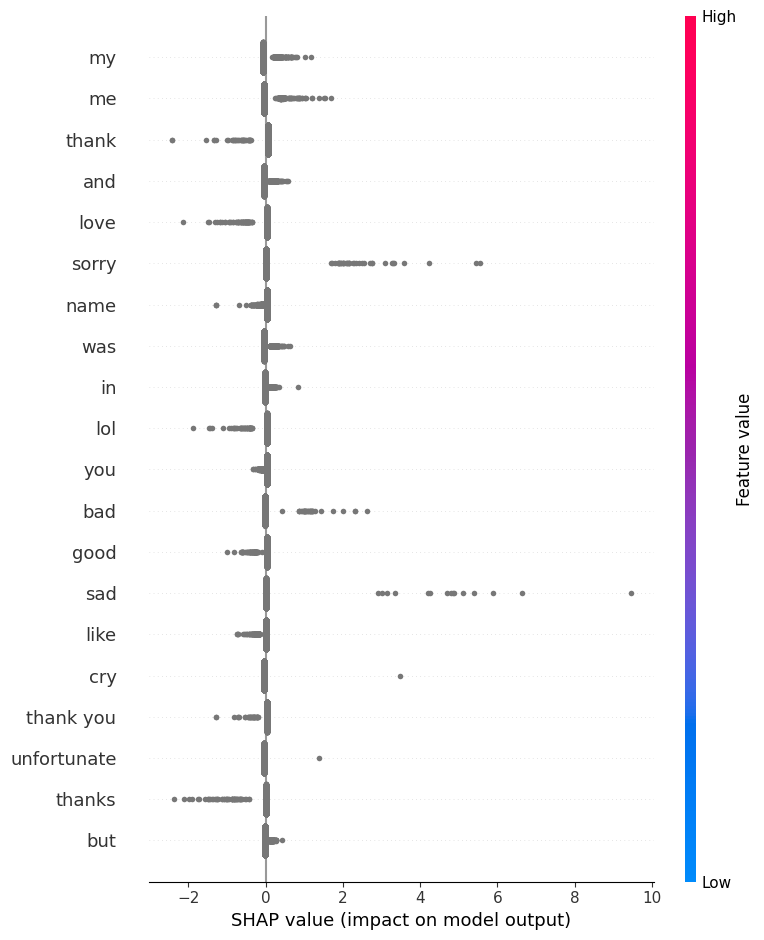

In [40]:
# Use a smaller subset for speed
N = 2000
X_bg = tfidf.transform(X_train[:N])
shap_vals_bg = explainer.shap_values(X_bg)

shap.summary_plot(shap_vals_bg, features=X_bg, feature_names=tfidf.get_feature_names_out())


In [41]:
!pip -q install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [42]:
import numpy as np
from lime.lime_text import LimeTextExplainer


In [43]:
# LIME needs class names for binary classification
class_names = [f"NOT_{target_label}", target_label]

# Prediction function for LIME
def predict_proba_for_lime(text_list):
    """
    Input: list of raw texts
    Output: array of shape (n_samples, 2) -> [P(not label), P(label)]
    """
    proba_pos = shap_pipe.predict_proba(text_list)[:, 1]   # P(label)
    proba_neg = 1 - proba_pos                              # P(not label)
    return np.vstack([proba_neg, proba_pos]).T


In [44]:
explainer_lime = LimeTextExplainer(class_names=class_names)

print("LIME explainer ready for label:", target_label)


LIME explainer ready for label: sadness


In [45]:
# Pick a sample text to explain (you can change index)
idx = 0
text_to_explain = X_val[idx]

print("TEXT:", text_to_explain)
print("Predicted prob:", shap_pipe.predict_proba([text_to_explain])[0][1])
exp = explainer_lime.explain_instance(
    text_to_explain,
    predict_proba_for_lime,
    num_features=12   # top words to show
)

# Show explanation inside notebook
exp.show_in_notebook(text=True)


TEXT: i find that a normal chat in chinese can sometimes have that effect too.
Predicted prob: 0.39140719828241677


In [46]:
print("Top word contributions for:", target_label)
for word, weight in exp.as_list():
    print(f"{word:<20}  weight={weight:+.4f}")


Top word contributions for: sadness
effect                weight=+0.0810
chinese               weight=+0.0704
too                   weight=+0.0654
find                  weight=-0.0640
chat                  weight=+0.0542
normal                weight=-0.0470
in                    weight=+0.0341
sometimes             weight=-0.0139
have                  weight=-0.0079
can                   weight=-0.0063
that                  weight=-0.0062
a                     weight=+0.0035


In [47]:
idx2 = 10
text2 = X_val[idx2]

exp2 = explainer_lime.explain_instance(
    text2,
    predict_proba_for_lime,
    num_features=12
)

print("TEXT:", text2)
print("Predicted prob:", shap_pipe.predict_proba([text2])[0][1])
exp2.show_in_notebook(text=True)


TEXT: you first! make it more interesting than this!
Predicted prob: 0.06691995332840299
